In [1]:
import mlfinlab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
help(mlfinlab)
# load data
data = pd.read_csv('./ES.csv')
data.shape

Help on package mlfinlab:

NAME
    mlfinlab - Package based on the text book: Advances in Financial Machine Learning, by Marcos Lopez de Prado

PACKAGE CONTENTS
    data_structures (package)
    features (package)
    filters (package)
    labeling (package)
    multi_product (package)
    sample_weights (package)
    sampling (package)
    tests (package)
    util (package)

SUBMODULES
    fracdiff
    microstructural

FILE
    /Users/maksimivanov/research/Chapter19/mlfinlab/__init__.py




(30228443, 8)

# Microstructure features

Market microstructure features aim to tease out useful information from the trading behavior of market participants on exchanges. These features have become more popular with the increased amount and granularity of data provided by exchanges. As a result, multiple models of liquidity, uncertainty, and price impact have emerged from this data.

## Chapter 19 Questions

### 19.1 From a time series of E-mini S&P 500 futures tick data, apply the tick rule to derive the series of trade signs

In [3]:
from mlfinlab.features.microstructural import tick_rule
data['aggressor'] = tick_rule(data['Price'])
data.head()

,Symbol,Date and Time,Price,Volume,Market Flag,Sales Condition,Exclude Record Flag,Unfiltered Price,aggressor
0,ESH17,2017/01/02 17:00:00.077,2240.75,1360,E,0,NaN,2240.75,1.0
1,ESH17,2017/01/02 17:00:00.140,2241.00,1,E,0,NaN,2241.00,1.0
2,ESH17,2017/01/02 17:00:00.140,2241.00,5,E,0,NaN,2241.00,1.0
3,ESH17,2017/01/02 17:00:00.140,2241.00,1,E,0,NaN,2241.00,1.0
4,ESH17,2017/01/02 17:00:00.140,2240.75,15,E,0,NaN,2240.75,-1.0


### 19.2 Compute the Roll Model on the time series of E-mini S&P 500 futures tick data.
#### a) What are the estimated values of noise and spread?

In [4]:
from mlfinlab.features.microstructural import roll_model
spread, noise = roll_model(data['Price'])
print(spread, noise)

0.6302213415311612 -0.784606875640145


#### b) Knowing that this contract is one of the most liquid products in the world and that it trades at the tightest possible spread, are these values in line with your expectations?

These values are not in line with the expectations. This can be explained by the fact that the data does not follow a random walk with no drift.

### 19.3 Compute high-low volatility estimator on E-mini S&P 500 futures tick data.
#### a) Using the weekly values, how does it differ from the std. dev. of close-to-close returns


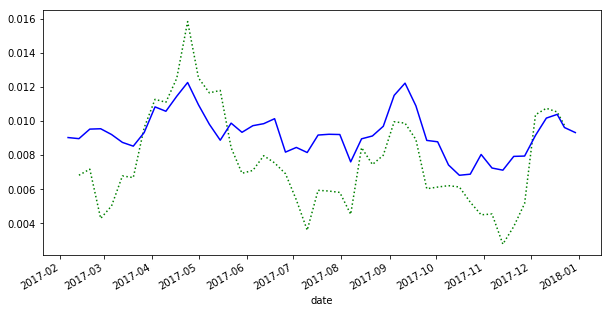

In [5]:
# first create weekly data 
new_data = pd.concat([data['Date and Time'], data['Price'], data['Volume']], axis=1)
new_data.columns = ['date', 'price', 'volume']
# new_data.to_csv('./maks_tick_data.csv', index=False)
new_data['date'] = pd.to_datetime(new_data['date'] )
new_data = new_data.set_index('date')





def ohlc(df):
    if df.empty: return df
    df['open'] = df.price.iloc[0]
    df['high'] = df.price.max()
    df['low'] = df.price.min()
    df['close'] = df.price.iloc[-1]
    return df[['open', 'high', 'low', 'close', 'volume']].iloc[-1:]
    
from mlfinlab.features.microstructural import high_low_estimator

weekly_data = new_data.groupby(pd.Grouper(freq='1W')).apply(lambda df: ohlc(df))
weekly_data.index = weekly_data.index.droplevel()
weekly_ret = weekly_data['close'].diff().iloc[1:] / weekly_data['close'].iloc[:-1]
weekly_ret_std = weekly_ret.rolling(window=5).std()
weekly_high_low_est = high_low_estimator(weekly_data['high'], weekly_data['low'], window=5)

plt.figure(figsize=(10,5))
weekly_ret_std.plot(color='green', style=':')
weekly_high_low_est.plot(color='blue')

#### b) Using daily values, how does this differ from the std. dev. of close-to-close returns?

/Users/maksimivanov/anaconda/envs/fml/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1142: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis, keys=keys)


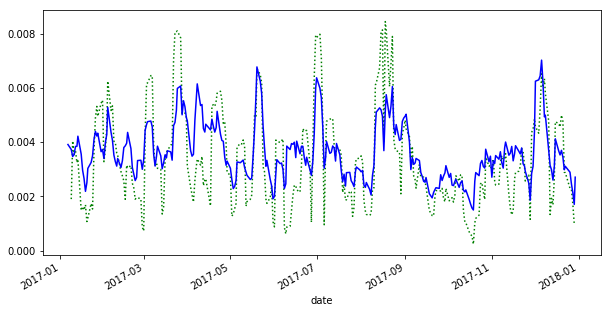

In [6]:
daily_data = new_data.groupby(pd.Grouper(freq='D'), as_index=False, sort=True).apply(lambda df: ohlc(df))
daily_data.index = daily_data.index.droplevel()
daily_ret = daily_data['close'].diff().iloc[1:] / daily_data['close'].iloc[:-1]
daily_ret_std = daily_ret.rolling(window=5).std()
daily_high_low_est = high_low_estimator(daily_data['high'], daily_data['low'], window=5)

plt.figure(figsize=(10,5))
daily_ret_std.plot(color='green', style=':')
daily_high_low_est.plot(color='blue')

##### c) Using dollar bars, for an average of 50 bars per day, how does this differ from the std. dev. of close-to-close returns?

In [7]:
# bars
# daily_dollar_volume = new_data.groupby(pd.Grouper(freq='D'), as_index=False).apply(lambda df: (df.price * df.volume).sum())
# avg_daily_dollar_volume= daily_dollar_volume.mean()
# thresh = int(avg_daily_dollar_volume / 50)

# from mlfinlab.data_structures import get_dollar_bars
# bars = get_dollar_bars('./maks_tick_data.csv', batch_size=1000000, verbose=True, threshold=thresh)



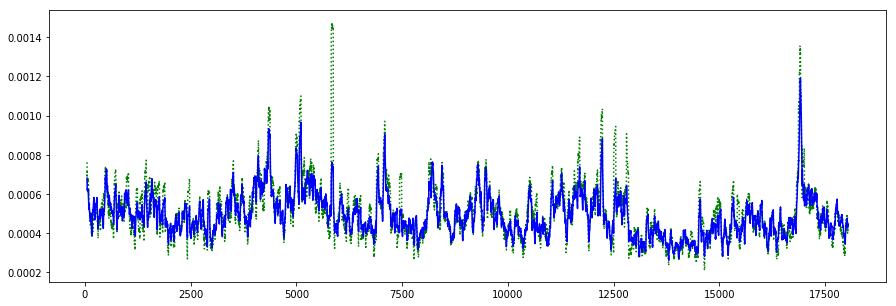

In [8]:
bars = pd.read_csv('dollar_bars.csv')
# bars = bars.set_index('date_time')
volume_bars_ret  = bars['close'].diff().iloc[1:] / bars['close'].iloc[:-1]
volume_bars_std = volume_bars_ret.rolling(window=50).std()
volume_bars_high_low_est = high_low_estimator(bars['high'], bars['low'], window=50)

plt.figure(figsize=(15,5))
volume_bars_std.plot(color='green', style=':')
volume_bars_high_low_est.plot(color='blue')


### 19.4 Apply the Corwin-Shultz estimator to a daily serie of E-mini S&P 500 futures
#### (a) What is the expected bid-ask spread?

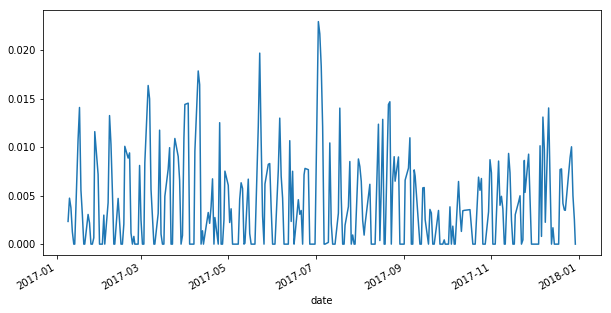

In [9]:
from mlfinlab.features.microstructural import corwin_shultz_spread
spread, start_ind = corwin_shultz_spread(daily_data['high'], daily_data['low'], sample_length=5)
plt.figure(figsize=(10, 5))
spread.plot()

#### (b) What is the implied volatility?

-0.6385178028142345


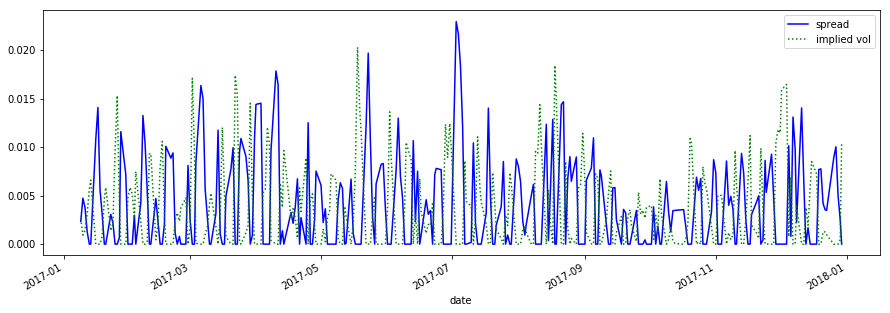

In [10]:
from mlfinlab.features.microstructural import becker_parkinson_volatility
volatility = becker_parkinson_volatility(daily_data['high'], daily_data['low'], sample_length=5)
plt.figure(figsize=(15, 5))
spread.plot(color='blue', label='spread')
volatility.plot(color='green', style=':', label='implied vol')
plt.legend()
print(spread.corr(volatility))

### 19.5 Compute Kyle's Lambda from:

#### (a) Tick data

In [11]:
from mlfinlab.features.microstructural import kyles_lambda
kyles_lambda(new_data['price'], new_data['volume'], tick_rule(new_data['price']))

0.0004366994582489916

#### (b) A time series of dollar bars on E-mini S&P futures where:

#### * b_t is the volume-weighted average of the trade signs, 

####  * V_t is the sum of the volumes in that bar

#### * delta_p is the change in price between two consecutive bars

In [12]:
from mlfinlab.data_structures import BarFeature, get_dollar_bars
from mlfinlab.features.microstructural import dollar_volume, tick_rule

vwa_trade_sign_feature = BarFeature(
    name='vwa_sign',
    function= lambda df: (tick_rule(df['price']) * df['volume']).mean()
    )
bars = get_dollar_bars('./maks_tick_data.csv', threshold=40000000, batch_size=1000000,
                       additional_features=[vwa_trade_sign_feature])



Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Batch number: 12
Batch number: 13
Batch number: 14
Batch number: 15
Batch number: 16
Batch number: 17
Batch number: 18
Batch number: 19
Batch number: 20
Batch number: 21
Batch number: 22
Batch number: 23
Batch number: 24
Batch number: 25
Batch number: 26
Batch number: 27
Batch number: 28
Batch number: 29
Batch number: 30
Returning bars 



In [13]:
kyles_lambda(bars['close'], bars['volume'], bars['vwa_sign'])

1.135071620172316e-05

### 19.6 Repeat exercise 5, this time applying Hasbroucks's Lambda. Are the results consistent?
#### (a) on tick data

In [21]:
from mlfinlab.features.microstructural import hasbroucks_lambda, hasbroucks_flow
hasb_flow = np.sqrt(new_data['price'] * new_data['volume']) * tick_rule(new_data['price'])
hasbroucks_lambda(new_data['price'], hasb_flow)

7.070994769242844e-08

#### (b) on dollar bars

In [23]:
hasbroucks_lambda(bars['close'], np.sqrt(bars['close'] * bars['volume']) * bars['vwa_sign'])

1.1893681269583971e-08

### 19.7 Repeat exercise 5, this time applying Amihud's Lambda. Are the results consistent?

#### (a) on tick data

In [24]:
from mlfinlab.features.microstructural import amihuds_lambda
amihuds_lambda(new_data['price'], new_data['price'] * new_data['volume'])

1.672647586792683e-11

#### (b) on dollar bars

In [28]:
amihuds_lambda(bars['close'], bars['high'] * bars['volume'])

2.2807118792751336e-11

### 19.8 From a time series of volume bars on the E-mini S&P 500 futures, compute the series of VPIN.

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



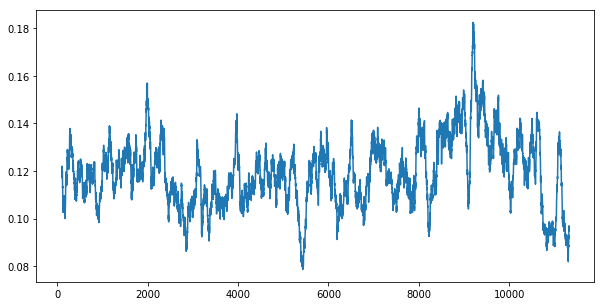

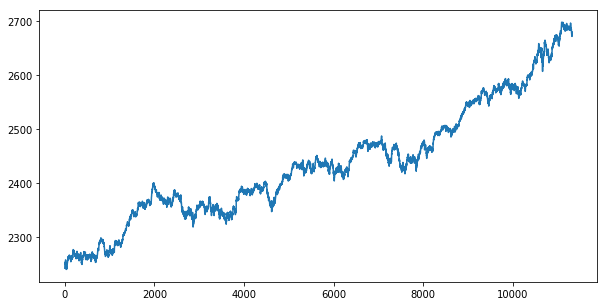

In [31]:
from mlfinlab.features.microstructural import vpin
from mlfinlab.data_structures import get_volume_bars

def buy_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs > 0)).sum()

def sell_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs < 0)).sum()
    
buy_volume_feature = BarFeature(name='buy_volume', function=buy_volume)
sell_volume_feature = BarFeature(name='sell_volume', function=sell_volume)

thresh = 28224
bars = get_volume_bars('./maks_tick_data.csv', threshold=thresh, verbose=True,
                       additional_features=[buy_volume_feature, sell_volume_feature])

vpin_series = vpin(bars['buy_volume'], bars['sell_volume'], thresh, 100)
plt.figure(figsize=(10, 5))
vpin_series.plot()
plt.figure(figsize=(10, 5))
bars['close'].plot()

## Additional Features